### Промежуточный проект

Проект e-commerce: вариант 1 

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

In [1]:
import pandas as pd
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from operator import attrgetter
import datetime
from datetime import timedelta

In [2]:
sns.set(
    font_scale = 2, 
    style = "whitegrid", 
    rc = {'figure.figsize':(20,14)})

In [3]:
customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-tulnikov-27/first_project/olist_customers_dataset.csv')
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-tulnikov-27/first_project/olist_orders_dataset.csv',  parse_dates=[3,4,5,6,7])
items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-tulnikov-27/first_project/olist_order_items_dataset.csv')

In [4]:
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [5]:
customers.shape

(99441, 5)

In [6]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [7]:
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04


In [8]:
orders.shape

(99441, 8)

In [9]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [10]:
items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [11]:
items.shape

(112650, 7)

In [12]:
items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

### 1.Сколько у нас пользователей, которые совершили покупку только один раз?

Посмотрим, какие сатусы заказа у нас имеются

In [13]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

delivered —  доставлен пользователю

shipped —  отгружен со склада

canceled —  отменён

unavailable —  недоступен

invoiced —  выставлен счёт

processing —  в процессе сборки заказа

created —  создан

approved —  подтверждён

Оставлю только статус delivered, так как товар уже доставлен и принят клиентом.

In [14]:
#Из orders возьмем только заказы со статусом delivered
orders_delivered = orders.query('order_status == "delivered"')
orders_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [15]:
uniq_customers = customers[['customer_unique_id', 'customer_id']]

orders_with_uniq_id = pd.merge(orders_delivered, uniq_customers, how='left')
orders_with_uniq_id = orders_with_uniq_id[['order_id', 'customer_id', 'order_status', 'customer_unique_id']]
orders_with_uniq_id.head()

,order_id,customer_id,order_status,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,72632f0f9dd73dfee390c9b22eb56dd6


In [16]:
orders_with_uniq_id.groupby('customer_unique_id', as_index=False) \
.agg({'order_id': 'count'}) \
.query('order_id == 1').shape[0]

90557

Количество клиентов с одним заказом - 90557

### 2.Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Возьмем статусы заказов canceled и unavailable, т.к нас интересуют не доставленные заказы.

In [17]:
orders_not_delivered = orders.query('order_status == "canceled" or order_status == "unavailable"')
orders_not_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05


In [18]:
orders_not_delivered.order_status.value_counts()

canceled       625
unavailable    609
Name: order_status, dtype: int64

In [19]:
count_orders_by_status = orders_not_delivered.groupby('order_status', as_index=False) \
.agg({'order_id': 'count'}) \
.rename(columns = {'order_id': 'count_orders'}) \
.sort_values('count_orders', ascending = False)
count_orders_by_status

,order_status,count_orders
0,canceled,625
1,unavailable,609


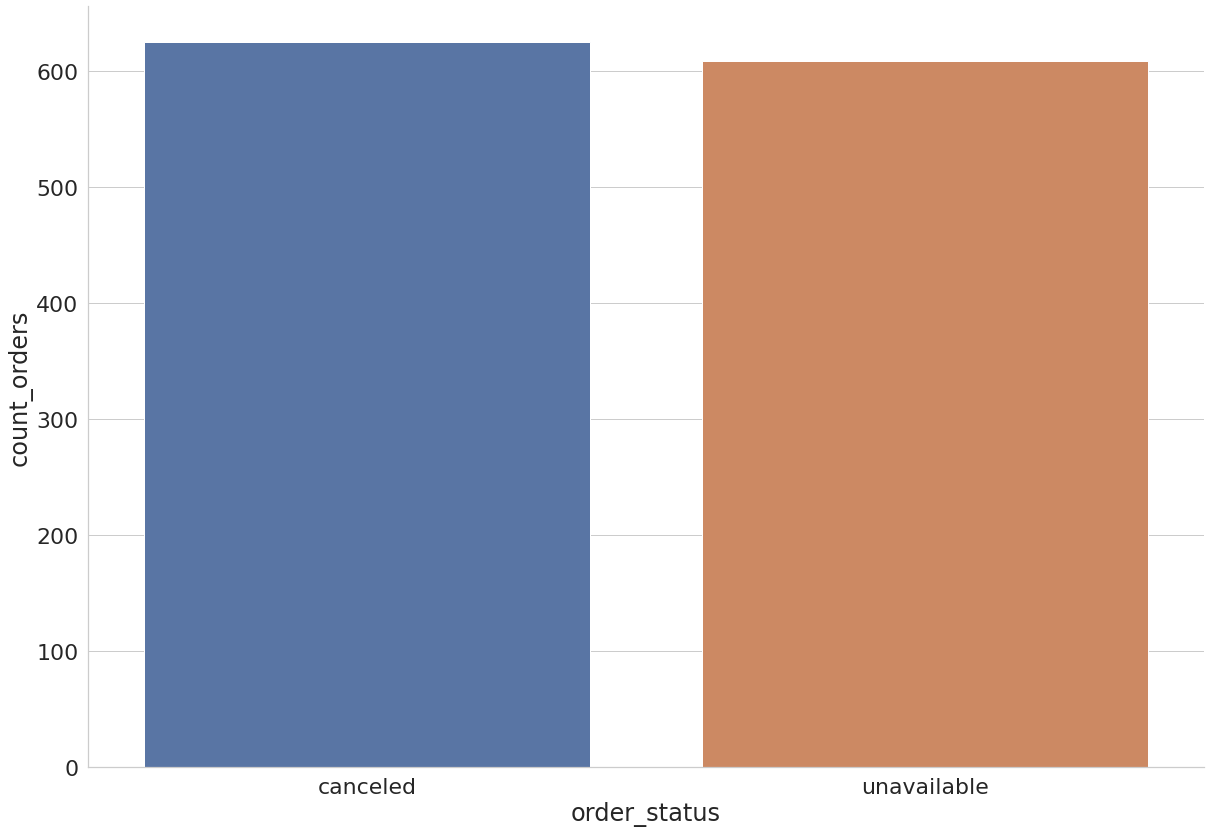

In [20]:
sns.barplot(data=count_orders_by_status, x="order_status", y="count_orders")
sns.despine()

In [21]:
orders_not_delivered['estimated_delivery'] = orders_not_delivered.order_estimated_delivery_date.apply(lambda x: x.strftime('%Y-%m'))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
not_delivered_by_month = orders_not_delivered.groupby(['estimated_delivery', 'order_status'], as_index = False) \
.agg({'order_id': 'count'})

In [23]:
not_delivered_by_month.groupby('order_status', as_index=False) \
.agg({'order_id': 'mean'}) \
.round(1)

,order_status,order_id
0,canceled,24.0
1,unavailable,29.0


### 3.По каждому товару определить, в какой день недели товар чаще всего покупается. 

Здесь нам понадобятся таблица заказов (orders) и товарные позиции, входящие в заказы (items). Джойним их по колонке order_id

In [24]:
orders_items = orders.merge(items, how='left', on = 'order_id')
orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [25]:
orders_items['day_of_the_week'] = orders_items['order_purchase_timestamp'].dt.day_name()

In [26]:
orders_items.product_id.nunique()

32951

In [27]:
orders_items = orders_items.groupby(['product_id', 'day_of_the_week'], as_index=False) \
.agg({'order_item_id': 'count'})
orders_items.head()

,product_id,day_of_the_week,order_item_id
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1


In [28]:
orders_items.pivot(index='product_id', columns='day_of_the_week', values='order_item_id') \
            .idxmax(axis=1) \
            .to_frame() \
            .reset_index() \
            .rename(columns={0:'most_popular_day'})

,product_id,most_popular_day
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,Saturday
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday
32948,fff9553ac224cec9d15d49f5a263411f,Friday
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

In [29]:
avg_buys = orders.query('order_status == "delivered"') \
.merge(customers, how='left', on='customer_id') \
[['customer_id', 'customer_unique_id', 'order_id', 'order_purchase_timestamp']]
avg_buys.head()

,customer_id,customer_unique_id,order_id,order_purchase_timestamp
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39


In [30]:
avg_buys.dtypes

customer_id                         object
customer_unique_id                  object
order_id                            object
order_purchase_timestamp    datetime64[ns]
dtype: object

In [31]:
avg_buys_orders = avg_buys.groupby(['customer_unique_id', 'order_purchase_timestamp'], as_index=False) \
.agg({'order_id': 'count'}) \
.rename(columns={'order_id': 'orders_by_month'})
avg_buys_orders.head()

,customer_unique_id,order_purchase_timestamp,orders_by_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1


In [32]:
avg_buys_orders['weeks'] = (avg_buys_orders['order_purchase_timestamp'].dt.daysinmonth) / 7
avg_buys_orders.head()

,customer_unique_id,order_purchase_timestamp,orders_by_month,weeks
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,4.428571
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,4.428571
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,4.428571
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,4.428571
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,4.285714


In [33]:
avg_buys_orders['orders_by_week'] = avg_buys_orders.orders_by_month / avg_buys_orders.weeks
avg_buys_orders.head()

,customer_unique_id,order_purchase_timestamp,orders_by_month,weeks,orders_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,4.428571,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,4.428571,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,4.285714,0.233333


In [34]:
buys_week = avg_buys_orders[['customer_unique_id', 'orders_by_week']]
buys_week

,customer_unique_id,orders_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.225806
2,0000f46a3911fa3c0805444483337064,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,0.225806
4,0004aac84e0df4da2b147fca70cf8255,0.233333
...,...,...
96206,fffcf5a5ff07b0908bd4e2dbc735a684,0.233333
96207,fffea47cd6d3cc0a88bd621562a9d061,0.225806
96208,ffff371b4d645b6ecea244b27531430a,0.250000
96209,ffff5962728ec6157033ef9805bacc48,0.225806


### 5.Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

Сделаем джоин orders и customers и так же оздадим 2 колонки (order_month)год-месяц покупки конкретного заказа и нашу когорту(cohort)самая первая покупка для конкретного пользователя

In [35]:
cohorts = orders.merge(customers, how='left', on='customer_id') \
                 [['customer_unique_id', 'order_id', 'order_purchase_timestamp']]
cohorts['order_month'] = cohorts['order_purchase_timestamp'].dt.to_period('M')
cohorts['cohort'] = cohorts.groupby('customer_unique_id')['order_month'].transform('min')
cohorts.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_month,cohort
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10,2017-09
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08,2018-08
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02,2018-02


In [36]:
cohorts = cohorts.groupby(['cohort', 'order_month']) \
.agg({'customer_unique_id': pd.Series.nunique}) \
.rename(columns={'customer_unique_id': 'num_customers'}) \
.reset_index()

In [37]:
cohorts.head()

,cohort,order_month,num_customers
0,2016-09,2016-09,4
1,2016-10,2016-10,321
2,2016-10,2017-04,1
3,2016-10,2017-07,1
4,2016-10,2017-09,1


Посчитаем сколько прошло месяцев между первой покупкой и датой покупки заказа

In [38]:
cohorts['period_number'] = (cohorts.order_month - cohorts.cohort).apply(attrgetter('n'))
cohorts.head()

,cohort,order_month,num_customers,period_number
0,2016-09,2016-09,4,0
1,2016-10,2016-10,321,0
2,2016-10,2017-04,1,6
3,2016-10,2017-07,1,9
4,2016-10,2017-09,1,11


In [39]:
cohort_group_size = pd.pivot_table(cohorts, values='num_customers', index='cohort',
    columns='period_number', aggfunc=np.sum)
cohort_group_size

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,321.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,764.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04,2352.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN,NaN,NaN
2017-05,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN


Посчитаем retention

In [40]:
cohort_size  = cohort_group_size.iloc[:,0]
cohort_size

cohort
2016-09       4.0
2016-10     321.0
2016-12       1.0
2017-01     764.0
2017-02    1752.0
2017-03    2636.0
2017-04    2352.0
2017-05    3596.0
2017-06    3139.0
2017-07    3894.0
2017-08    4184.0
2017-09    4130.0
2017-10    4470.0
2017-11    7304.0
2017-12    5487.0
2018-01    7025.0
2018-02    6451.0
2018-03    6965.0
2018-04    6711.0
2018-05    6622.0
2018-06    5940.0
2018-07    6071.0
2018-08    6271.0
2018-09       5.0
2018-10       1.0
Freq: M, Name: 0, dtype: float64

In [41]:
retention_rate = cohort_group_size.divide(cohort_size, axis = 0).mul(1) #в визуализации переведу в %
retention_rate

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003115,NaN,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,0.006231,0.006231
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.003927,0.002618,0.001309,0.003927,0.001309,0.005236,0.001309,0.001309,NaN,0.003927,0.001309,0.007853,0.003927,0.001309,0.001309,0.002618,0.003927,0.001309,NaN
2017-02,1.0,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,0.002854,0.001712,0.001712,0.001142,0.000571,0.000571,0.002283,NaN,NaN
2017-03,1.0,0.004932,0.003794,0.003794,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,0.003794,0.001517,0.002276,0.001138,0.001517,0.002276,0.000759,0.001517,NaN,NaN
2017-04,1.0,0.005952,0.002126,0.001701,0.003401,0.002551,0.003401,0.002976,0.002976,0.001701,0.002551,0.000850,0.000850,0.000425,0.000850,0.000850,0.002126,NaN,NaN,NaN
2017-05,1.0,0.005006,0.005006,0.003893,0.003059,0.003337,0.004171,0.001669,0.002503,0.003059,0.002503,0.003337,0.002503,0.000278,0.001947,0.002503,NaN,NaN,NaN,NaN
2017-06,1.0,0.004779,0.003504,0.004141,0.002549,0.003823,0.003823,0.002230,0.001274,0.002230,0.003186,0.003504,0.001593,0.001274,0.001911,NaN,NaN,NaN,NaN,NaN


In [42]:
style = (retention_rate
            .style
            .set_caption('Retention Rate по месячным когортам пользователей')
            .background_gradient(cmap='PuBu') 
            .highlight_null('white') 
            .format("{:.2%}", na_rep=""))

style

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,,,,,,,,
2016-10,100.00%,,,,,,0.31%,,,0.31%,,0.31%,,0.31%,,0.31%,,0.31%,0.62%,0.62%
2016-12,100.00%,100.00%,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.39%,0.26%,0.13%,0.39%,0.13%,0.52%,0.13%,0.13%,,0.39%,0.13%,0.79%,0.39%,0.13%,0.13%,0.26%,0.39%,0.13%,
2017-02,100.00%,0.23%,0.29%,0.11%,0.40%,0.11%,0.23%,0.17%,0.17%,0.23%,0.11%,0.29%,0.17%,0.17%,0.11%,0.06%,0.06%,0.23%,,
2017-03,100.00%,0.49%,0.38%,0.38%,0.34%,0.15%,0.15%,0.30%,0.34%,0.08%,0.38%,0.15%,0.23%,0.11%,0.15%,0.23%,0.08%,0.15%,,
2017-04,100.00%,0.60%,0.21%,0.17%,0.34%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.21%,,,
2017-05,100.00%,0.50%,0.50%,0.39%,0.31%,0.33%,0.42%,0.17%,0.25%,0.31%,0.25%,0.33%,0.25%,0.03%,0.19%,0.25%,,,,
2017-06,100.00%,0.48%,0.35%,0.41%,0.25%,0.38%,0.38%,0.22%,0.13%,0.22%,0.32%,0.35%,0.16%,0.13%,0.19%,,,,,


Видим, что возвращаемость клиентов очень низкая на протяжении всех месяцев.

Визуально на графике видно, что с самым высоким retention на 3й месяц показатель у когорты 0.41% '2017-06'.

 
### 6.Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

В кластеризации можешь выбрать следующие метрики:

R - время от последней покупки пользователя до текущей даты,

F - суммарное количество покупок у пользователя за всё время,

M - сумма покупок за всё время.

Подробно опиши, как ты создавал кластеры.Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней,frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

In [43]:
cust_orders = customers.merge(orders, on='customer_id')
cust_orders = cust_orders.merge(items)[['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'order_status', 'price']]
cust_orders = cust_orders.query('order_status == "delivered"') #Оставим только завершенные заказы
cust_orders.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_status,price
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,delivered,124.99
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,delivered,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,delivered,139.94
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,delivered,149.94
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,delivered,230.00


Вместо текущей даты для дельты между текущей датой и датой последней покупки возьмем дату самой последней покупки из таблицы + 1 день.

In [44]:
date_max = max(cust_orders.order_purchase_timestamp) + timedelta(days=1)

Считаем метрики

Recency - дельта, которая показывает, когда была совершена последняя покупка. Чем этот показатель ниже, тем нам лучше.

In [45]:
Recency = cust_orders.groupby('customer_unique_id', as_index=False) \
.agg({'order_purchase_timestamp': lambda x: (date_max - x.max()).days}) \
.rename(columns={'order_purchase_timestamp': 'Recency'})

Recency['Recency'] = Recency['Recency'].astype('int16')
Recency.head(3)

,customer_unique_id,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115
2,0000f46a3911fa3c0805444483337064,537


Frequency - считаем число заказов на одного пользователя.

In [46]:
Frequency = cust_orders.groupby('customer_unique_id', as_index=False) \
.agg({'order_purchase_timestamp': 'count'}) \
.rename(columns={'order_purchase_timestamp': 'Frequency'})

Frequency.head(3)

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1


Monetary - считаем суммарную сумму, потраченную пользователем.

In [47]:
Monetary = cust_orders.groupby('customer_unique_id', as_index=False) \
.agg({'price': 'sum'}) \
.rename(columns={'price': 'Monetary'})

Monetary.head(3)

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.9
2,0000f46a3911fa3c0805444483337064,69.0


Джойним полученые df

In [48]:
RFM = Recency.merge(Frequency, on = 'customer_unique_id').merge(Monetary)
RFM.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00


### Recency

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


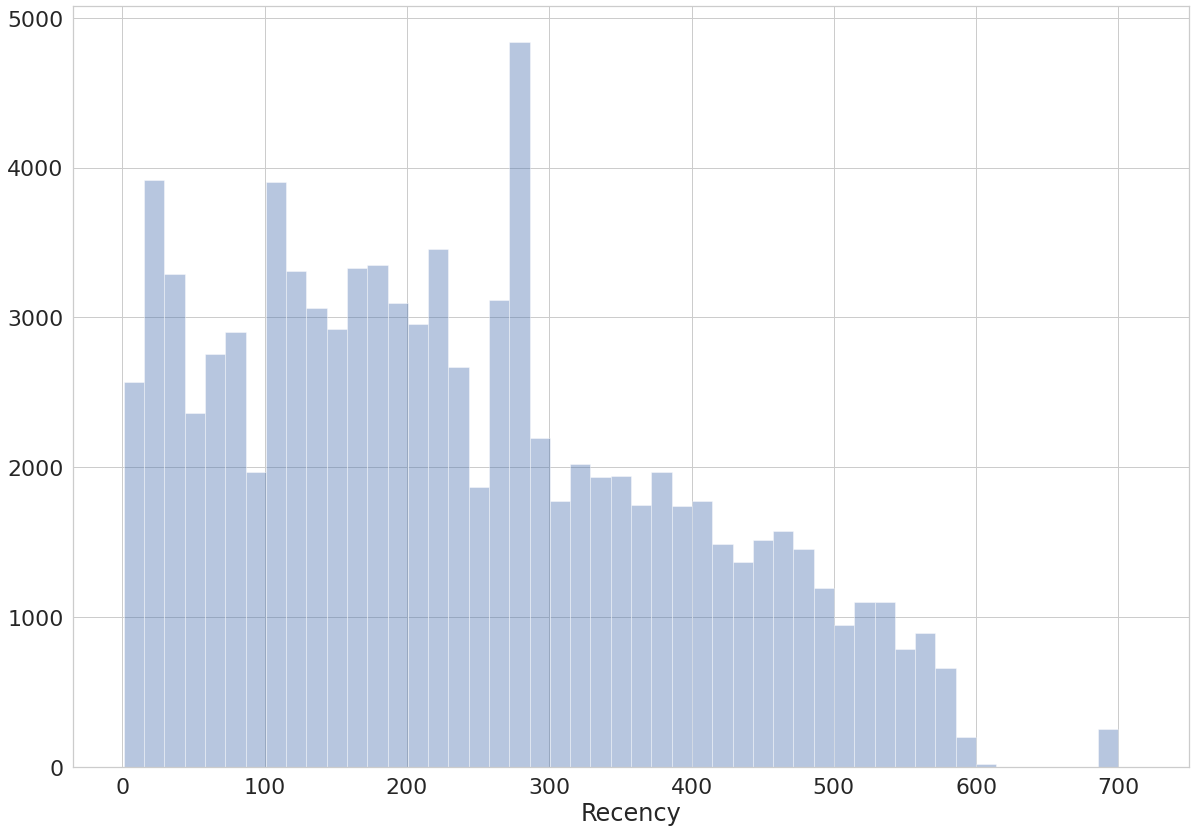

In [49]:
sns.distplot(RFM.Recency, kde=False)

In [50]:
print(RFM.Recency.quantile(q=0.33))
print(RFM.Recency.quantile(q=0.66))

147.0
286.0


In [51]:
def r(Recency):
    if Recency <= 147:
        return 3
    elif Recency <= 286:
        return 2
    else:
        return 1

RFM['R'] = RFM.Recency.apply(r)

### Frequency

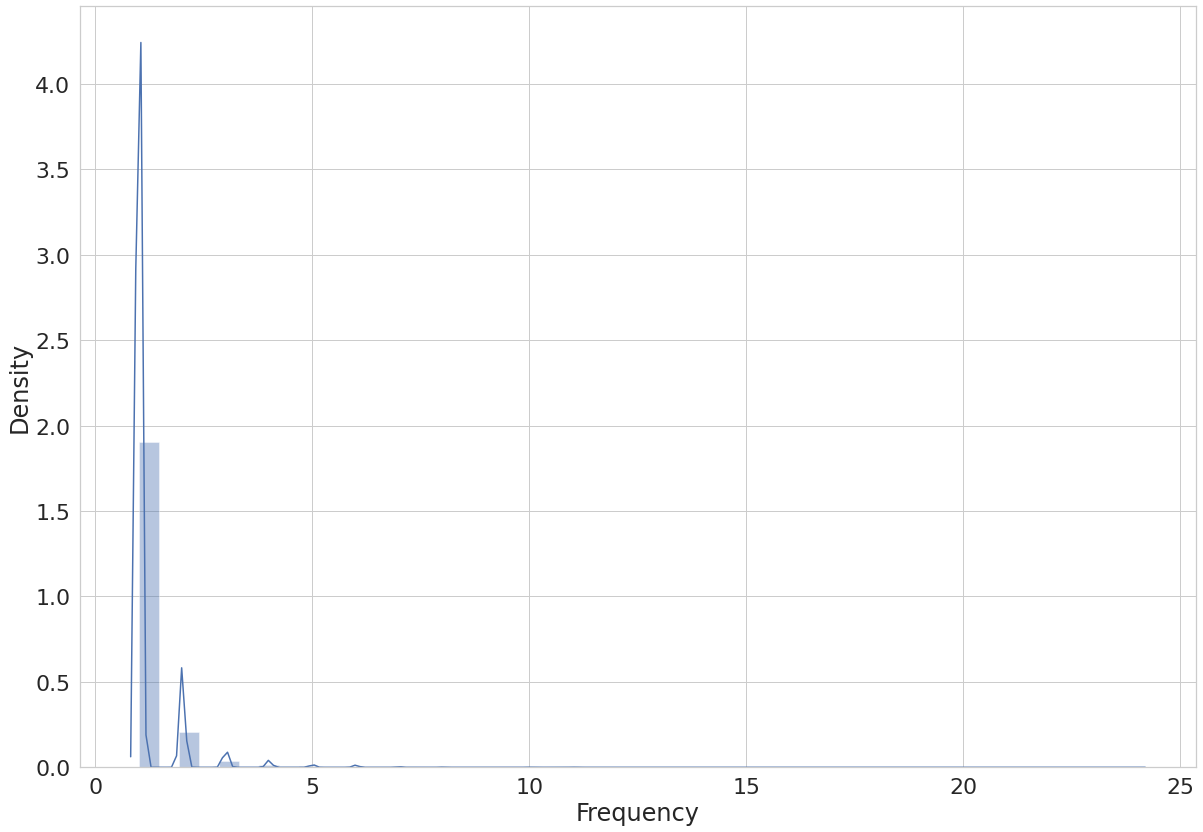

In [52]:
sns.distplot(RFM.Frequency)

In [53]:
RFM[RFM.Frequency == 1].Frequency.sum() / RFM.Frequency.sum()

0.7418350771799596

Болшинство покупателей совершили только 1 покупку 

разобъем на три группы.

1 - 1 покупка

2 - 2 покупки

3 - 3 и более покупок

In [54]:
def F(Frequency):
    if Frequency == 1:
        return 1
    elif Frequency == 2:
        return 2
    else:
        return 3

RFM['F'] = RFM.Frequency.apply(F)

### Monetary

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


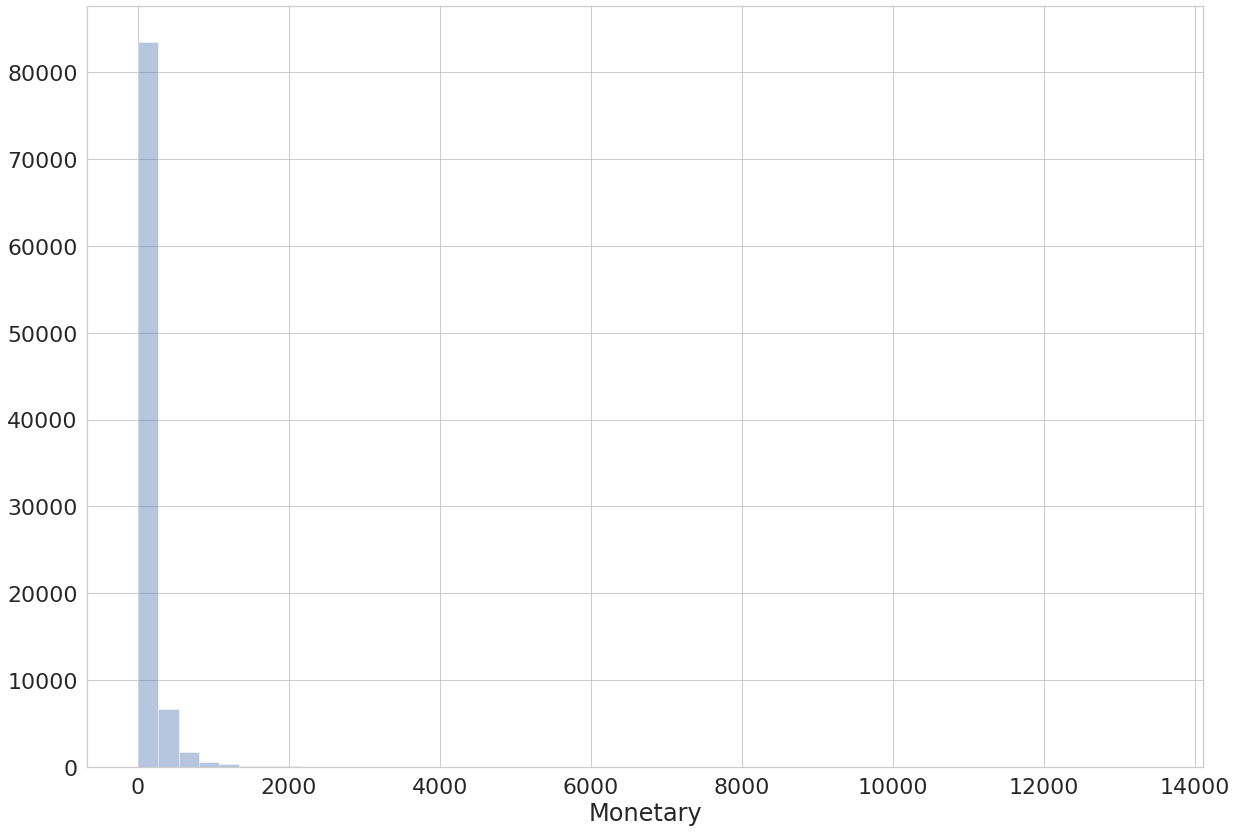

In [55]:
sns.distplot(RFM.Monetary, kde=False)

In [56]:
print(RFM.Monetary.quantile(q=0.33))
print(RFM.Monetary.quantile(q=0.66))

57.9
124.9


In [57]:
def M(Monetary):
    if Monetary <= 57.9:
        return 1
    elif Monetary <= 124.9:
        return 2
    else:
        return 3

RFM['M'] = RFM.Monetary.apply(M)

In [58]:
RFM.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,1,1,3


In [59]:
RFM['RFM'] = RFM['R'].astype(str) + RFM['F'].astype(str) + RFM['M'].astype(str)
RFM.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,3,313
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,1,1,3,113


Результирующая таблица по каждому покупателю, с отношением его к определенному RFM-кластеру готова.

Посмотрим сколько пользователей относиться к определенному кластеру

In [60]:
count_customer_RFM = RFM.groupby('RFM', as_index = False) \
.agg({'customer_unique_id': 'count'}) \
.rename(columns = {'customer_unique_id': 'count_of_customer'})
count_customer_RFM.head()

,RFM,count_of_customer
0,111,9855
1,112,9477
2,113,8515
3,121,497
4,122,1066


In [61]:
sns.color_palette("flare", as_cmap=True)

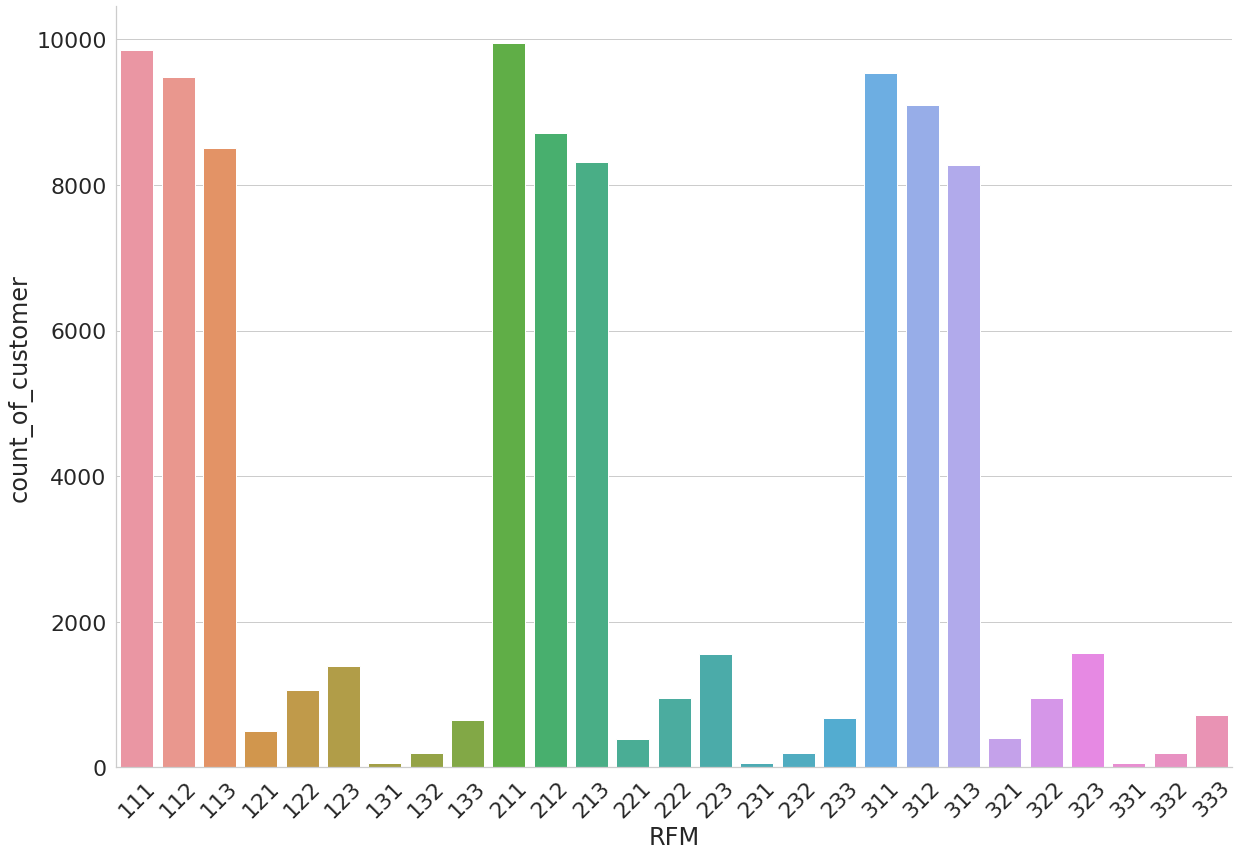

In [62]:
ax = sns.barplot(x='RFM', y='count_of_customer', data=count_customer_RFM)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
sns.despine()
plt.show()

Барплот показывает количество относящихся к определенному кластеру клиентов.

Разделим на сегменты

333 Недавно покупавшие частые с высоким чеком   - VIP

332 Недавно покупавшие частые со средним чеком  - Выгодные

331 Недавно покупавшие частые с низким чеком    - Выгодные

323 Недавно покупавшие редкие с высоким чеком   - Потенциально выгодные

322 Недавно покупавшие редкие со средним чеком  - Потенциально выгодные

321 Недавно покупавшие редкие с низким чеком    - Потенциально выгодныее

313 Недавно покупавшие разовые с высоким чеком  - Новенькие

312 Недавно покупавшие разовые со средним чеком - Новенькие

311 Недавно покупавшие разовые с низким чеком   - Новенькие

233 Спящие частые с высоким чеком               - Спящие выгодные

232 Спящие частые со средним чеком              - Спящие выгодные

231 Спящие частые с низким чеком                - Спящие выгодные

223 Спящие редкие с высоким чеком               - Спящие выгодные

222 Спящие редкие со средним чеком              - Спящие выгодные

221 Спящие редкие с низким чеком                - Спящие

213 Спящие разовые с высоким чеком              - Спящие

212 Спящие разовые со средним чеком             - Спящие

211 Спящие разовые с низким чеком               - Спящие

133 Давние частые с высоким чеком               - Уходящие выгодные

132 Давние частые со средним чеком              - Уходящие выгодные

131 Давние частые с низким чеком                - Уходящие

123 Давние редкие с высоким чеком               - Уходящие

122 Давние редкие со средним чеком              - Уходящие

121 Давние редкие с низким чеком                - Потерянные

113 Давние разовые с высоким чеком              - Потерянные

112 Давние разовые со средним чеком             - Потерянные

111 Давние разовые с низким чеком               - Потерянные

In [63]:
segt_map = {
    r'333': 'VIP',
    r'33[1-2]': 'Выгодные',
    r'32[1-3]': 'Потенциально выгодные',
    r'31[1-3]': 'Новенькие',
    r'23[1-3]': 'Спящие выгодные',
    r'22[2-3]': 'Спящие выгодные',
    r'21[1-3]': 'Спящие',
    r'221': 'Спящие',
    r'13[2-3]': 'Уходящие выгодные',
    r'12[2-3]': ' Уходящие',
    r'131': ' Уходящие',
    r'11[1-3]': 'Потерянные',
    r'121': 'Потерянные'
}

RFM['Segment'] = RFM['RFM'].replace(segt_map, regex=True)
RFM.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,3,313,Новенькие
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1,311,Новенькие
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112,Потерянные
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1,111,Потерянные
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,1,1,3,113,Потерянные


In [67]:
RFM.Segment.nunique()

9

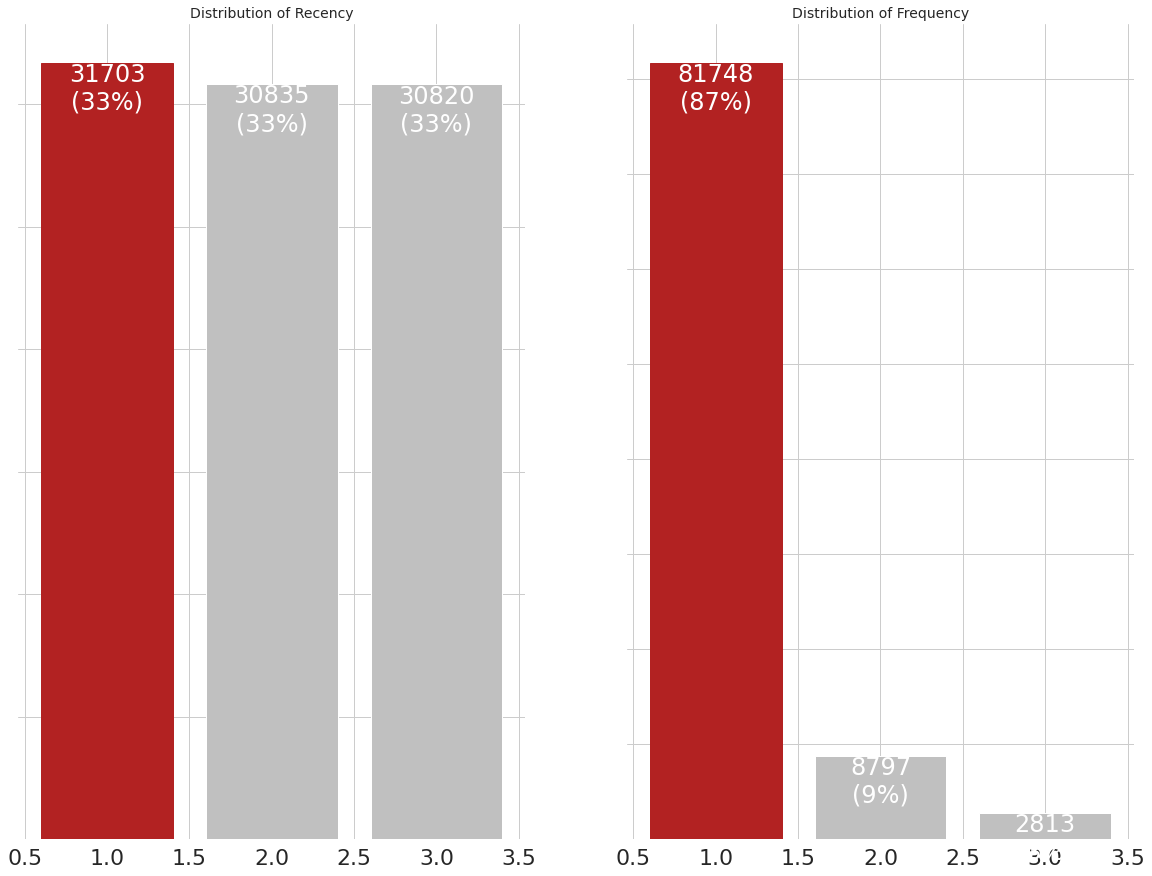

In [70]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = RFM[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

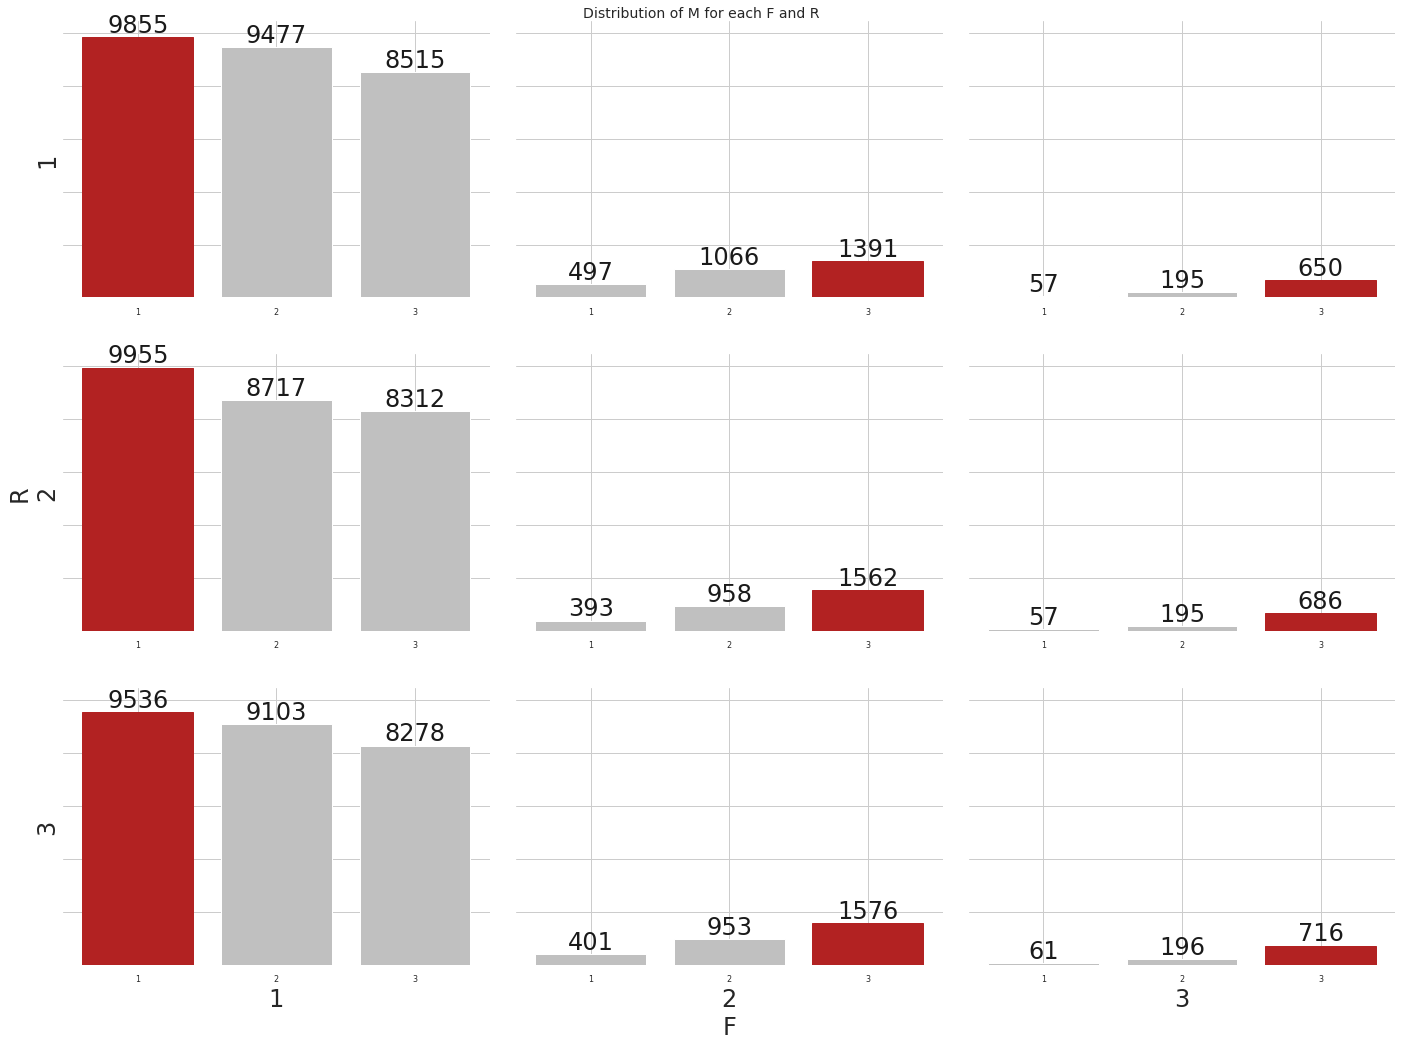

In [72]:
# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=3, ncols=3,
                         sharex=False, sharey=True,
                         figsize=(20, 15))

r_range = range(1, 4)
f_range = range(1, 4)
for r in r_range:
    for f in f_range:
        y = RFM[(RFM['R'] == r) & (RFM['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 3:
            if f == 2:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 2:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

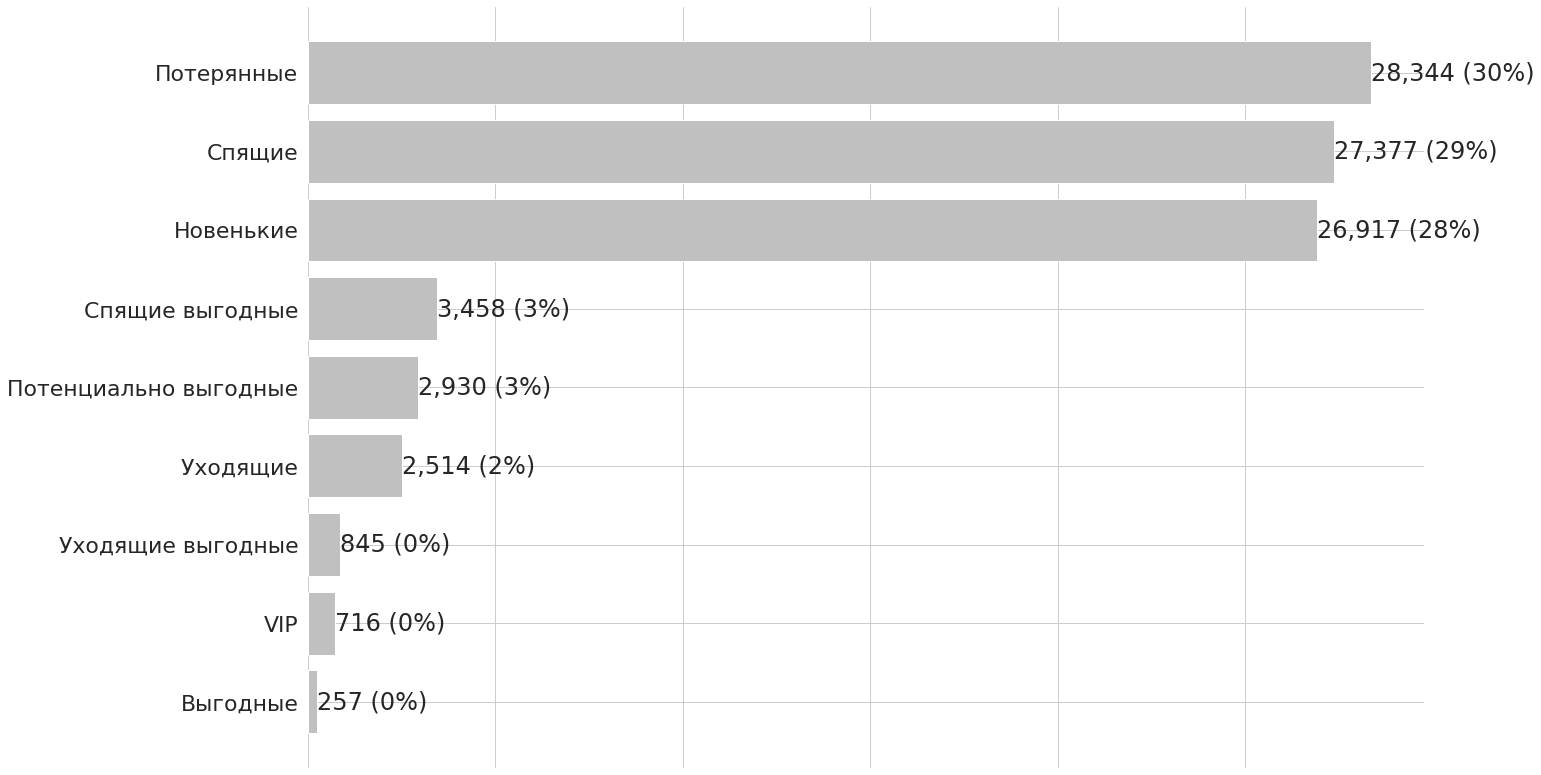

In [73]:
# count the number of customers in each segment
segments_counts = RFM['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()